In [2]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Step 2: Set up data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
    ]),
}

# Step 3: Load datasets and create dataloaders
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'validation': datasets.ImageFolder(validation_dir, data_transforms['validation']),
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'validation': DataLoader(image_datasets['validation'], batch_size=32, shuffle=False),
}

# Step 4: Load the pretrained ResNet model and modify for binary classification
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# Step 5: Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

--2024-11-06 03:21:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 172.217.15.251, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   240MB/s    in 0.3s    

2024-11-06 03:21:55 (240 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [4]:
# Step 6: Define the training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete")
    return model

# Step 7: Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.1995 Acc: 0.9085
validation Loss: 0.0932 Acc: 0.9580
Epoch 2/10
----------
train Loss: 0.1851 Acc: 0.9235
validation Loss: 0.0942 Acc: 0.9630
Epoch 3/10
----------
train Loss: 0.1720 Acc: 0.9235
validation Loss: 0.0948 Acc: 0.9620
Epoch 4/10
----------
train Loss: 0.1774 Acc: 0.9235
validation Loss: 0.0908 Acc: 0.9600
Epoch 5/10
----------
train Loss: 0.1711 Acc: 0.9220
validation Loss: 0.0885 Acc: 0.9620
Epoch 6/10
----------
train Loss: 0.1810 Acc: 0.9225
validation Loss: 0.0970 Acc: 0.9600
Epoch 7/10
----------
train Loss: 0.1617 Acc: 0.9310
validation Loss: 0.0937 Acc: 0.9610
Epoch 8/10
----------
train Loss: 0.1618 Acc: 0.9290
validation Loss: 0.0914 Acc: 0.9630
Epoch 9/10
----------
train Loss: 0.1753 Acc: 0.9270
validation Loss: 0.0922 Acc: 0.9580
Epoch 10/10
----------
train Loss: 0.1609 Acc: 0.9350
validation Loss: 0.0904 Acc: 0.9610
Training complete


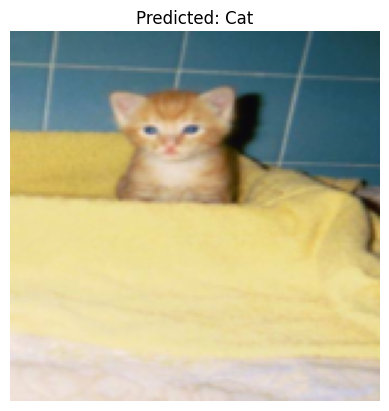

In [7]:

def make_single_prediction(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
        class_name = "Dog" if pred.item() == 1 else "Cat"

    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(f"Predicted: {class_name}")
    plt.axis("off")
    plt.show()

sample_image_path = os.path.join(validation_dir, 'cats', os.listdir(os.path.join(validation_dir, 'cats'))[0])
make_single_prediction(model, sample_image_path)